In [8]:
import numpy as np
import os
import pandas as pd
import librosa
import librosa.display
from scipy import signal
from scipy import fftpack  # Fourier
from scipy.ndimage import maximum_filter1d
from scipy import stats
from librosa.feature import mfcc, spectral_contrast, zero_crossing_rate
from tsfresh.feature_extraction import feature_calculators as fc
import pywt
from bokeh.plotting import figure, show
from tqdm.notebook import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA




### Loading

In [9]:
def load_window_from_csv(file_path):
    return pd.read_csv(file_path)


def process_windowed_csv_files(directory, feature_extraction_func, save_dir):
    for file in tqdm(os.listdir(directory), desc="Processing files"):
        if file.endswith('.csv'):
            file_path = os.path.join(directory, file)
            window_df = load_window_from_csv(file_path)
            all_features = []
            for column in window_df.columns[:-2]:  # Exclude metadata columns
                window_features = feature_extraction_func(window_df[column], column)
                all_features.append(window_features)
            features_df = pd.concat(all_features, ignore_index=True)

            # Save the features to the specified directory
            save_path = os.path.join(save_dir, file.replace('.csv', '_features.csv'))
            features_df.to_csv(save_path, index=False)

### Feature Engineering

In [ ]:
all_features_train = pd.DataFrame()

for station_id in tqdm(train.columns[1:], desc="Processing Stations"):
    sig = train[station_id]

    # Fourier transform and other calculations
    fourier = fftpack.fft(sig.values)
    real, imag = np.real(fourier), np.imag(fourier)
    
    # Temporal features
    temp_features = {
        f"{station_id}_mean": [sig.mean()],
        f"{station_id}_var": [sig.var()],
        f"{station_id}_skew" : [sig.skew()],
        f"{station_id}_delta" : [sig.max() - sig.min()],
        f"{station_id}_mad" : [(sig - sig.mean()).abs().mean()],
        f"{station_id}_kurtosis" : [sig.kurtosis()],
        f"{station_id}_sem" : [sig.sem()],
        f"{station_id}_q5" : [np.quantile(sig, 0.05)],
        f"{station_id}_q25": [np.quantile(sig, 0.25)],
        f"{station_id}_q75" : [np.quantile(sig, 0.75)],
        f"{station_id}_q95" : [np.quantile(sig, 0.95)],
        # Add more features here...
    }

    freq_features = {
        f"{station_id}_real_mean" : [real.mean()],
        f"{station_id}_real_var" : [real.var()],
        f"{station_id}_real_delta" : [real.max() - real.min()],
        f"{station_id}_imag_mean" : [imag.mean()],
        f"{station_id}_imag_var" : [imag.var()],
        f"{station_id}_imag_delta" : [imag.max() - imag.min()],
        f"{station_id}_nb_peak" : fc.number_peaks(sig.values, 2),
        f"{station_id}_median_roll_std" : np.median(pd.Series(sig).rolling(50).std().dropna().values),
        f"{station_id}_autocorr5" : fc.autocorrelation(sig, 5),
        f"{station_id}_nb_peak_3": fc.number_peaks(sig.values, 3),
        f"{station_id}_absquant95" : np.quantile(np.abs(sig), 0.95),
    }

    # Advanced features
    adv_features = {}
    try:
        # Mel-frequency cepstral coefficients (MFCCs)
        mfccs = librosa.feature.mfcc(y=sig.values, sr=22050, n_mfcc=20)  # Adjust sr as needed
        mfccs_mean = mfccs.mean(axis=1)
        for i, mfcc_mean in enumerate(mfccs_mean):
            adv_features[f"{station_id}_mfcc_mean_{i}"] = mfcc_mean

        # Spectral contrast
        spec_contrast = librosa.feature.spectral_contrast(y=sig.values, sr=22050)
        spec_contrast_mean = spec_contrast.mean(axis=1)
        for i, contrast in enumerate(spec_contrast_mean):
            adv_features[f"{station_id}_spec_contrast_mean_{i}"] = contrast
        
        # Other cepstral or spectral features can be added here
    except Exception as e:
        print(f"Error processing advanced features for {station_id}: {e}")

    # Combine temporal and frequencial features
    features = {**temp_features, **freq_features, **adv_features}
    
    # Print calculated features for each sensor
    print(f"\nFeatures for {station_id}:")
    for feature, value in features.items():
        # Check if value is a list or a scalar
        if isinstance(value, list):
            print_val = value[0]
        else:
            print_val = value
        print(f"{feature}: {print_val}")

    # Convert to DataFrame
    sensor_features_df = pd.DataFrame([features])
    all_features_train = pd.concat([all_features_train, sensor_features_df], axis=1)

# Fill missing values and print final DataFrame
all_features_train.fillna(-1, inplace=True)
print("\nAll Features for Train Dataset:")
print(all_features_train.head())

In [10]:
def get_features(sig, station_id):
    """Analysis of a signal. Grabs temporal and frequential features.
    Returns a pandas dataframe"""

    fourier = fftpack.fft(sig.values)
    real, imag = np.real(fourier), np.imag(fourier)

    # Temporal data
    features = {}
    features[f"{station_id}_mean"] = [sig.mean()]
    features[f"{station_id}_var"] = [sig.var()]
    features[f"{station_id}_skew"] = [sig.skew()]
    features[f"{station_id}_delta"] = [sig.max() - sig.min()]
    features[f"{station_id}_mad"] = [(sig - sig.mean()).abs().mean()]
    features[f"{station_id}_kurtosis"] = [sig.kurtosis()]
    features[f"{station_id}_sem"] = [sig.sem()]
    features[f"{station_id}_q5"] = [np.quantile(sig, 0.05)]
    features[f"{station_id}_q25"] = [np.quantile(sig, 0.25)]
    features[f"{station_id}_q75"] = [np.quantile(sig, 0.75)]
    features[f"{station_id}_q95"] = [np.quantile(sig, 0.95)]
    grad_rol_max = [maximum_filter1d(np.gradient(np.abs(sig.values)), 50)]
    delta = np.max(grad_rol_max) - np.min(grad_rol_max)
    features[f"{station_id}_grmax_delta"] = delta

    # Frequencial
    features[f"{station_id}_real_mean"] = [real.mean()]
    features[f"{station_id}_real_var"] = [real.var()]
    features[f"{station_id}_real_delta"] = [real.max() - real.min()]

    features[f"{station_id}_imag_mean"] = [imag.mean()]
    features[f"{station_id}_imag_var"] = [imag.var()]
    features[f"{station_id}_imag_delta"] = [imag.max() - imag.min()]

    features[f"{station_id}_nb_peak"] = fc.number_peaks(sig.values, 2)
    features[f"{station_id}_median_roll_std"] = np.median(
        pd.Series(sig).rolling(50).std().dropna().values)
    features[f"{station_id}_autocorr5"] = fc.autocorrelation(sig, 5)

    # Added 16
    features[f"{station_id}_nb_peak_3"] = fc.number_peaks(sig.values, 3)
    features[f"{station_id}_absquant95"] = np.quantile(np.abs(sig), 0.95)

    try:
        # Mel-frequency cepstral coefficients
        mfcc_mean = mfcc(sig.values).mean(axis=1)
        for i in range(20):
            features[f"{station_id}_mfcc_mean_{i}"] = mfcc_mean[i]
        # Contrast spectral
        spec_contrast = spectral_contrast(sig.values).mean(axis=1)
        for i in range(7):
            features[f"{station_id}_lib_spec_cont_{i}"] = spec_contrast[i]
        features[f"{station_id}_zero_cross"] = zero_crossing_rate(sig)[0].mean()
        # Added 16
        features[f"{station_id}_percentile_roll20_std_50"] = np.percentile(
            sig.rolling(20).std().dropna().values, 50)

    except:
        pass

    return pd.DataFrame.from_dict(features)

In [12]:
windowed_train_dir = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWS/data/train'
windowed_test_dir = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWS/data/test'

features_train_dir = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWS/data/features/train'
features_test_dir = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWS/data/features/test'
os.makedirs(features_train_dir, exist_ok=True)
os.makedirs(features_test_dir, exist_ok=True)

process_windowed_csv_files(windowed_train_dir, get_features, features_train_dir)
process_windowed_csv_files(windowed_test_dir, get_features, features_test_dir)



### Exploratory Data Analysis (EDA)

In [ ]:
# Histograms for each feature
train_features.hist(bins=50, figsize=(20,15))
plt.suptitle("Distribution of Features")
plt.show()

In [ ]:
# Boxplot for each feature
plt.figure(figsize=(20, 8))
sns.boxplot(data=train_features)
plt.xticks(rotation=90)
plt.title("Boxplot of Features")
plt.show()

In [ ]:
# Correlation matrix
corr_matrix = train_features.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

#### Dimensionality Reduction

In [31]:
from sklearn.decomposition import PCA

# PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Adjust n_components as needed
train_reduced = pca.fit_transform(train_features)

print("Number of PCA components:", pca.n_components_)


Number of PCA components: 1


/usr/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


In [35]:
# Assuming the first column is the timestamp
train_numeric = train.drop(train.columns[0], axis=1)

n_clusters_options = [2, 3, 4, 5, 6]  # Example cluster options

# Use tqdm to display progress
for n_clusters in tqdm(n_clusters_options, desc="Fitting K-Means"):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(train_numeric)


/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5)

In [36]:
# Example with a specific number of clusters
kmeans = KMeans(n_clusters=5)
kmeans.fit(train_numeric)

# Cluster assignments
cluster_labels = kmeans.labels_

# Add cluster labels to your DataFrame for analysis
train_numeric['cluster'] = cluster_labels


/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


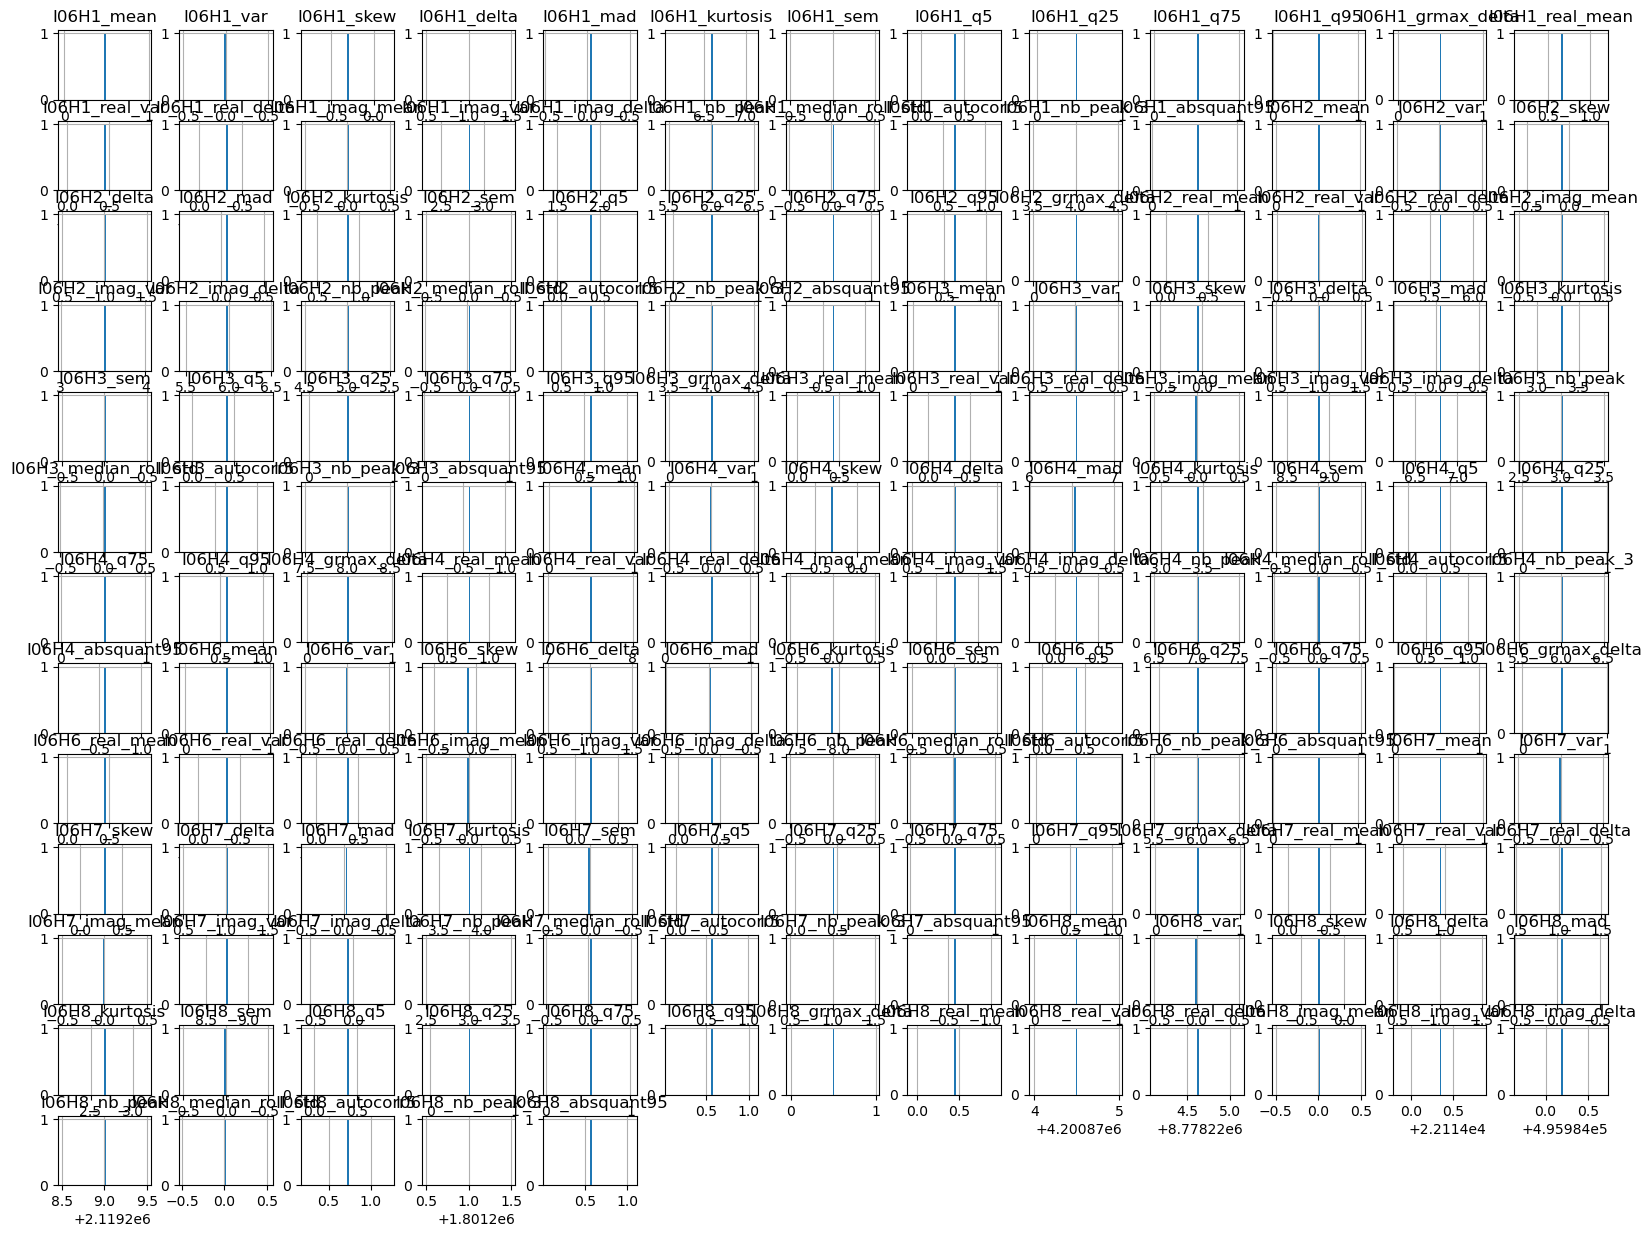

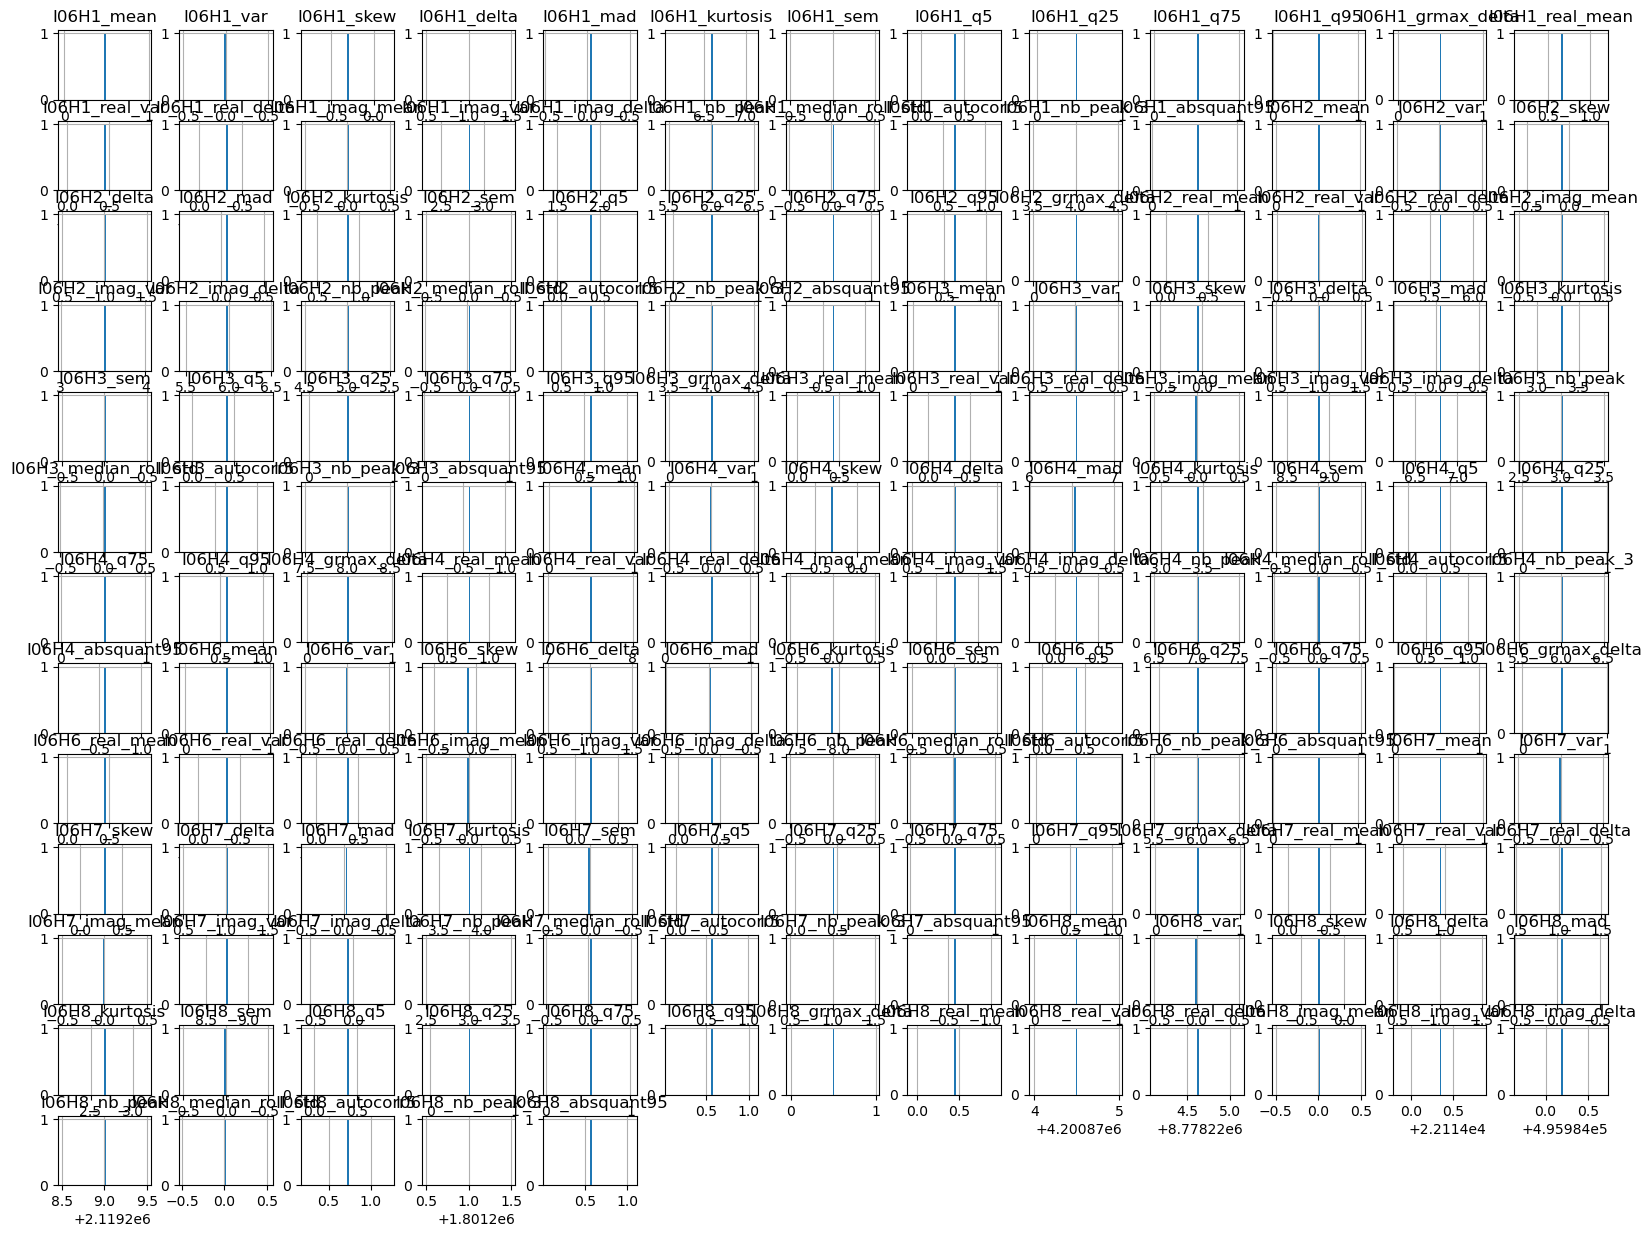

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [37]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce dimensions for visualization (2D)
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(train_numeric.drop('cluster', axis=1))

# Scatter plot of the two PCA components
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_features[:,0], y=reduced_features[:,1], hue=train_numeric['cluster'], palette='Set2')
plt.title('Cluster Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [ ]:
# Centroids
centroids = kmeans.cluster_centers_

# If you reduced the dimensions for visualization, inverse transform the centroids
centroids_pca = pca.inverse_transform(centroids)

# Create a DataFrame for easier analysis
centroid_df = pd.DataFrame(centroids_pca, columns=train_numeric.columns[:-1])
print(centroid_df)
